In [162]:
import geopandas
import pandas
import rioxarray
import pathlib
import shutil
import numpy
import scipy
import time
import xarray

In [163]:
remote_path = pathlib.Path(r"\\niwa.local\projects\wellington\CARH2306\Working\TCGabrielle_Feb2023\Sediment Sampling")
base_path = pathlib.Path(r"C:\Local\data\CARH2306")
dem_name = "CycloneGabrielle_EskValley_DEM_preliminary.tif"
dem_path = remote_path / ".." / "EskValley_DEM_NZTM2000" / dem_name
shutil.copy(dem_path, base_path);

In [164]:
crs = {"vertical": 7869, "horizontal": 2193}

## Still Todo
@Steph
1. Strip "beach sample" from Comments column of sites. See Filtering sediments 2. Flip the sizes dataframe for an example
2. Work out what is going on with the negative 1000 value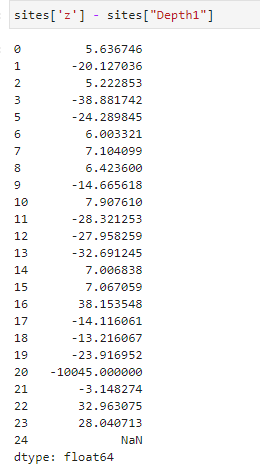

## Filtering sediments
Match the two datasets to only keep entries in both. Steps:
1. Load in sizes and sites and drop unneeded columns
2. Flip the sizes dataframe
3. Bring the sizes into the sites dataframe
4. Filter the sites dataframes to only retain locations with sizes

#### 1. Load in sizes and sites and drop unneeded columns

In [192]:
sites = geopandas.read_file(
    remote_path / "Fine_Sediment_Sampling_Sites_Esk" / 
    "Actual Sediment Sampling Locations Esk Valley - Actual Sampling Locations Esk Valley.shp")
sites.drop(columns=['SampleType', 'TotalDepth', 'NumLayers', 'Depth2', 'Depth3', 
                            'Depth4', 'Depth5', 'Depth6', 'GlobalID'], inplace=True)
sites = sites.to_crs(crs["horizontal"])
sizes = pandas.read_excel(
    remote_path / "SedimentAnalysis_Steph" / "EskValley_ParticleSize_cumul.xlsx", sheet_name="Surface_Wentworth")

#### 2. Flip the sizes dataframe
* Transpose
* Set column names to sediment type and drop particle sizes
* Tidy the index to match the sites

In [193]:
sizes = sizes.transpose()
sizes.columns = sizes.iloc[0]
sizes.drop(sizes.index[[0, 1]], inplace=True)
sizes.index = sizes.index.str.replace("-0", "").str.replace("-1", "")

#### Bring sizes into the sites dataframe

In [194]:
def get_size(row: geopandas.GeoDataFrame, sizes: pandas.DataFrame, sediment_type:str):
    """ Function to filter the column values by sites"""
    if row["Comments"] in sizes.index:
        return sizes[sediment_type][row["Comments"] == sizes.index].iloc[0]
    else:
        return numpy.nan

In [195]:
for sediment_type in sizes.columns:
    sites[sediment_type] = sites.apply(lambda row: get_size(row, sizes=sizes, sediment_type=sediment_type), axis='columns')

#### Filter the sites to retain only locations with sizes

In [196]:
sites = sites[numpy.logical_not(sites.isna().any(axis=1))]

## Points to grid
Interpolate from points to a grid. Steps:
1. x & y grid from DEM
2. x & y arrays from sites
3. Interpolate

#### 1. x & y grid from DEM

In [197]:
surface_dem = rioxarray.open_rasterio(base_path / dem_name)
grid_x, grid_y = numpy.meshgrid(surface_dem.x, surface_dem.y)

#### 2. grid_x, grid_y = numpy.meshgrid(surface_dem.x, surface_dem.y)

In [198]:
sites['x'] = sites.apply(lambda row: row.geometry.x, axis='columns')
sites['y'] = sites.apply(lambda row: row.geometry.y, axis='columns')

#### 3. Caclulate depth
Note interpolate first as a value returned the -9999 no fill values

In [ ]:
surface_dem = surface_dem.rio.interpolate_na(method="linear")

In [ ]:
sites['z'] = sites.apply(lambda row: float(surface_dem.interp(x=row.geometry.x, y=row.geometry.y)), axis='columns')

In [ ]:
sites['z']

#### 3. Interpolate

In [ ]:
depth1_grid = scipy.interpolate.griddata(
    points=(sites['x'], sites['y']),
    values=sites['z'] - sites["Depth1"],
    xi=(grid_x, grid_x),
    method="nearest",  # linear or cubic
            )

In [ ]:
sediment_dem = xarray.Dataset(
    data_vars=dict(
        sediment_depth=(
            ["y", "x"],
            depth1_grid,
            {
                "units": "m",
                "long_name": "depth1",
                "vertical_datum": f"EPSG:{crs['vertical']}",
            },
        ),
        SiltClay=(
            ["y", "x"],
            depth1_grid,
            {
                "units": "m",
                "long_name": "The silt-clay proportion",
                "vertical_datum": f"EPSG:{crs['vertical']}",
            },
        ),
    ),
    coords=dict(x=(["x"], grid_x[0]), y=(["y"], grid_y[:, 0])),
    attrs={
        "title": "Sediment elevations and proportions",
        "description": "The sediment_depth layer contains xx, the other layers define the volume/proprtion/depth of that sediment at each location",
        "history": f"Created by Steph Mangan for CARH2306: {time.gmtime()}",
    },
)

In [ ]:
sediment_dem.to_netcdf(base_path / "dem_with_sediment.nc")